In [1]:
import pyforest

Look at each model’s uncertainty for the exact same molecule in the test set


1. find all UQ metric values for test set compounds 
2. get all molecules that are used in the test set
3. make comparions across all models in the same test set (separate GP/RF)
4. maybe try comparing same models but different NEKs


The dfs were obtained from the notebook where I got all the compound names and compared their classification type (tn/fp/fn/fp)  

In [2]:
def get_tree_probabilities(model, x_data): 
    test_proba0_df = pd.DataFrame()
    test_proba1_df = pd.DataFrame()
    for tree_num in np.arange(len(model.estimators_)):
        test_proba_temp = model.estimators_[tree_num].predict_proba(x_data)
        test_proba0_df[tree_num] = test_proba_temp[:,0]
        test_proba1_df[tree_num] = test_proba_temp[:,1]
    std0 = test_proba0_df.std(axis=1)
    std1 = test_proba1_df.std(axis=1)
    return std0, std1

In [22]:
def add_prediction_type(row): 
    if row['y'] == 1 and row['prediction'] == 1:
        return 'TP'
    elif row['y'] == 0 and row['prediction'] == 0:
        return 'TN'
    elif row['y'] == 0 and row['prediction'] == 1:
        return 'FP'
    elif row['y'] == 1 and row['prediction'] == 0:
        return 'FN'

def calc_pred_type(y_true, y_pred): 
    pred_type = 'err'
    if y_true == 0: 
        if y_pred == 1:
            pred_type='FP'
        else: 
            pred_type='TN'
    else: # if y_true==1
        if y_pred==0:
            pred_type='FN'
        else: 
            pred_type='TP'
    return pred_type

def len_lst(cmpd_lst):
    return len(cmpd_lst) 
    

# RF model uncertainty: tree probability agreement

In [135]:
og_df_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition']
model_types = ['GP', 'RF']
feat_types=['MFP']
RF_types = ['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW'] 
samplings = ['none_scaled','UNDER','SMOTE']
rf_ts1_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_results/'
gp_ts1_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/GP_results/'
cmpd_df_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/compound_TNFPFNTP/'


col_order = ['NEK', 'feat_type', 'strategy','modeling_type', 'compound_id', 'active', 'prediction' , 'RF_type']
compound_col_order = ['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version', 'set']
nanobret_RF='/Users/jayceepang/msse/ATOM_CODE/examples/holdout/holdout_results/jp_holdout_summer2025/RF2?/'
nanobret_GP='/Users/jayceepang/msse/ATOM_CODE/examples/holdout/holdout_results/jp_holdout_summer2025/GP/'
nb_datapath='/Users/jayceepang/msse/ATOM_CODE/datasets/holdout_data/featurized/'
# df = pd.read_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_{model_name}_cmpd_class.csv')
og_datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
rf_model_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_results/'

remove_cols = ['NEK', 'compound_id', 'base_rdkit_smiles', 'active', 'subset'] 
new_cmpd_df_path = '/Users/jayceepang/msse/ATOM_CODE/UQ/compound_TNFPFNTP/'
for nek in neks:
    short_nek = nek[:4] 
    for samp in samplings: 
        og_full_df = pd.read_csv(f'{og_df_path}{nek}_MFP_{samp}.csv')
        og_test=og_full_df[og_full_df['subset']=='test'] 
        drop_cols=['NEK'	,'compound_id',	'base_rdkit_smiles',	'subset'	,'active']
        og_x_data=og_test.drop(columns=drop_cols).to_numpy()
        print(og_test.shape)

        nb_df = pd.read_csv(f'{nb_datapath}{short_nek}_MFP_none_unscaled.csv')
        nb_test=nb_df[nb_df['subset']=='test'] 
        nb_x_data=nb_test.drop(columns=drop_cols).to_numpy()

        for rf in RF_types:
            with open(f'{rf_ts1_path}{nek}_MFP_{samp}_{rf}_prod.pkl', 'rb') as f: 
                model = pickle.load(f) 
            std0, std1=get_tree_probabilities(model, og_x_data)
            
            print(f'{nek} MFP {samp} {rf}')
            model_name=rf
            og_rf_results = pd.read_csv(f'{rf_ts1_path}{nek}_MFP_{samp}_{rf}_prod_test.csv')
            og_rf_results['prediction_type'] = og_rf_results.apply(add_prediction_type, axis=1)
            # same_order = np.array_equal(og_test['active'].to_numpy(),og_rf_results['y'].to_numpy())
            # print('is equal?', same_order)
            
            df = og_rf_results.reset_index(drop=True)
            df['compound_id'] = og_test['compound_id'].reset_index(drop=True)
            df['uq_0']=std0 # use if 
            df['uq_1']=std1
             
            df['UQ_metric_value'] = df.apply(lambda x:x['uq_0'] if x['prediction_type'] in ['TN','FN'] else x['uq_1'], axis=1)
            df['model_version']=f'{samp}_{rf}'
            df['modeling_type'] = 'RF'
            df = df.rename(columns={'y':'active'})
            df['set'] = 'test'
            df = df[compound_col_order]
            df.to_csv(f'{new_cmpd_df_path}test_set/{nek}_MFP_{samp}_{model_name}_cmpd_class.csv', index=False)


            
            nb_std0, nb_std1=get_tree_probabilities(model, nb_x_data)
            nb_rf_results= pd.read_csv(f'{nanobret_RF}{short_nek}_{nek}_MFP_{samp}_{rf}_holdout_test.csv')
            nb_rf_results['prediction_type'] = nb_rf_results.apply(add_prediction_type, axis=1)
            nb_df = nb_rf_results.reset_index(drop=True)

            # same_order_nb = np.array_equal(nb_test['active'].to_numpy(),nb_rf_results['y'].to_numpy())
            # print('is equal nb?', same_order_nb)
            nb_df['compound_id'] = nb_test['compound_id'].reset_index(drop=True)
            nb_df['uq_0']=nb_std0 # use if 
            nb_df['uq_1']=nb_std1
            nb_df['UQ_metric_value'] = nb_df.apply(lambda x:x['uq_0'] if x['prediction_type'] in ['TN','FN'] else x['uq_1'], axis=1)
            nb_df['model_version']=f'{samp}_{rf}'
            nb_df['modeling_type'] = 'RF'
            nb_df = nb_df.rename(columns={'y':'active'})
            nb_df['set'] = 'nanobret'
            nb_df = nb_df[compound_col_order]
            nb_df.to_csv(f'{new_cmpd_df_path}nanobret/{nek}_{short_nek}_MFP_{samp}_{model_name}_cmpd_class.csv', index=False)
           

            
      #       print(df.columns) Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
      #  'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
      #  'UQ_metric_value', 'model_version'],
      # dtype='object')
            

<IPython.core.display.Javascript object>

(283, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP none_scaled RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP none_scaled BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(283, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(283, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(407, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(407, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(407, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(282, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(282, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(282, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(248, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(248, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(248, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(283, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(283, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(283, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(80, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(80, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(80, 2053)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE RF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# GP uncertainty: predictive variance

In [204]:
gp_col_order = ['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version', 'set']
for nek in neks:
    short_nek = nek[:4]
    for samp in samplings: 
        print(f'{nek} MFP {samp} GP_matern')
        og_gp_results_df = pd.read_csv(f'{gp_ts1_path}{nek}_MFP_{samp}_matern_prod_test.csv')
        og_gp_results_df=og_gp_results_df.rename(columns={'y_pred': 'prediction', 'y':'active'})
        og_gp_results_df['prediction_type'] = og_gp_results_df.apply(lambda x:calc_pred_type(x['active'] ,x['prediction']), axis=1)
        og_full_df = pd.read_csv(f'{og_df_path}{nek}_MFP_{samp}.csv')
        og_test = og_full_df.loc[og_full_df['subset'] == 'test'].reset_index(drop=True)
        df = og_gp_results_df.reset_index(drop=True)
        assert len(df) == len(og_test), (
            f'Length mismatch: GP results ({len(df)}) '
            f'vs test set ({len(og_test)})')
        df['compound_id'] = og_test['compound_id']
      
        
        # df = pd.read_csv(f'{cmpd_df_path}{nek}_MFP_{samp}_GP_matern_cmpd_class.csv')
       #  ['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       # 'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       # 'UQ_metric_value', 'model_version']
        
        df['prediction_type'] = df.apply(lambda x:calc_pred_type(x['active'] ,x['active']), axis=1)

        df['uq_0'] = df['var_pred_class0']
        df['uq_1'] = df['var_pred_class1']


        df['uq_0']=df['var_pred_class0']
        df['uq_1']=df['var_pred_class1']
        df['RF_type'] = 'GP_matern'
        df['modeling_type'] ='GP'
     


        df['UQ_metric_value'] = df.apply(lambda x:x['uq_0'] if x['prediction_type'] in ['TN','FN'] else x['uq_1'], axis=1)
        df['UQ_metric_value'] = df['uq_0']  # Default to uq_0
        df.loc[df['prediction_type'].isin(['TP', 'FP']), 'UQ_metric_value'] = df['uq_1']
        df['model_version']=f'{samp}_GP_matern'
        df['set'] ='test'
        df=df[gp_col_order]
        assert df['compound_id'].isna().sum() == 0
        assert df['uq_0'].isna().sum() == 0
        assert df['uq_1'].isna().sum() == 0
        assert df['UQ_metric_value'].isna().sum() == 0

    
        df.to_csv(f'{new_cmpd_df_path}test_set/{nek}_MFP_{samp}_GP_matern_cmpd_class.csv', index=False)

        nb_gp_results_df = pd.read_csv(f'{nanobret_GP}{short_nek}_MFP_none_scaled_{nek}_{samp}_GP_matern_nanobret_cellular_holdout.csv')
        nb_gp_results_df=nb_gp_results_df.rename(columns={'y_pred': 'prediction', 'y':'active'})
        nb_gp_results_df['prediction_type'] = nb_gp_results_df.apply(lambda x:calc_pred_type(x['active'] ,x['prediction']), axis=1)
        nb_df = pd.read_csv(f'{nb_datapath}{short_nek}_MFP_none_unscaled.csv')
        nb_test=nb_df[nb_df['subset']=='test'] 


        # same_order_nb = np.array_equal(nb_test['active'].to_numpy(),nb_gp_results_df['active'].to_numpy())
        # print('is equal? nb', same_order_nb)
            

        nb_df = nb_gp_results_df
        nb_df['compound_id'] = nb_test['compound_id'].reset_index(drop=True)
        nb_df['prediction_type'] = nb_df.apply(lambda x:calc_pred_type(x['active'] ,x['active']), axis=1)
        nb_df['uq_0']=nb_df['var_pred_class0']
        nb_df['uq_1']= nb_df['var_pred_class1']
        nb_df['RF_type'] = f'{samp}_GP_matern'
        nb_df['modeling_type'] ='GP'
        nb_df['UQ_metric_value'] = nb_df.apply(lambda x:x['uq_0'] if x['prediction_type'] in ['TN','FN'] else x['uq_1'], axis=1)
        nb_df['UQ_metric_value'] =  nb_df['uq_0']  # Default to uq_0
        nb_df.loc[nb_df['prediction_type'].isin(['TP', 'FP']), 'UQ_metric_value'] = df['uq_1']
        nb_df['model_version']=f'{samp}_GP_matern'
        nb_df['set'] = 'nanobret'
        nb_df=nb_df[gp_col_order]    
        nb_df.to_csv(f'{new_cmpd_df_path}nanobret/{nek}_{short_nek}_MFP_{samp}_GP_matern_cmpd_class.csv', index=False)


NEK2_binding MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [205]:
# make df of all models for 1 nek 
all_uq_dfs = []
all_nb_uq_dfs=[]
for nek in neks:
    nek_df=[]
    nek_dfs = []
    for samp in samplings: 
        for model in ['GP_matern']+ RF_types:
            df = pd.read_csv(f'{new_cmpd_df_path}test_set/{nek}_MFP_{samp}_{model}_cmpd_class.csv')
            
            df['NEK']=nek
            df['feat_type'] ='MFP'
            df['strategy']=samp
            df['model']=model
            df['set'] = 'test'
            all_uq_dfs.append(df)

            nek_dfs.append(df)

    full_df = pd.concat(nek_dfs, ignore_index=True)
    print(full_df.shape)
    
    full_df.to_csv(f'{new_cmpd_df_path}test_set/{nek}_all_models_testset.csv',index=False)


uq_df = pd.concat(all_uq_dfs, ignore_index=True)
uq_df.to_csv(f'{new_cmpd_df_path}test_set/UQ_all_mols_all_models_testset.csv',index=False)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(4245, 15)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(6105, 15)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(4230, 15)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(3720, 15)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(4245, 15)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(1200, 15)


<IPython.core.display.Javascript object>

In [206]:
nb_all_uq_dfs = []
for nek in neks:
    nb_nek_df=[]
    short_nek = nek[:4]
    nb_nek_dfs = []
    for samp in samplings: 
        for model in ['GP_matern']+ RF_types:
            nb_df = pd.read_csv(f'{new_cmpd_df_path}nanobret/{nek}_{short_nek}_MFP_{samp}_{model}_cmpd_class.csv')

            nb_df['NEK']=nek
            nb_df['feat_type'] ='MFP'
            nb_df['strategy']=samp
            nb_df['model']=model
            nb_df['set'] = 'nanobret'
            nb_all_uq_dfs.append(nb_df)
            nb_nek_dfs.append(nb_df)
    nb_full_df=pd.concat(nb_nek_dfs,axis=0)
    nb_full_df.to_csv(f'{new_cmpd_df_path}nanobret/{nek}_all_models_nanobret.csv', index=False)
nb_uq_df = pd.concat(nb_all_uq_dfs, ignore_index=True)
nb_uq_df.to_csv(f'{new_cmpd_df_path}nanobret/UQ_all_mols_all_models_nanobret.csv', index=False)       


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. Find all common compounds in test sets for 1 nek at a time

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

nekdf nas sum:  uq_0    0
uq_1    0
dtype: int64


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

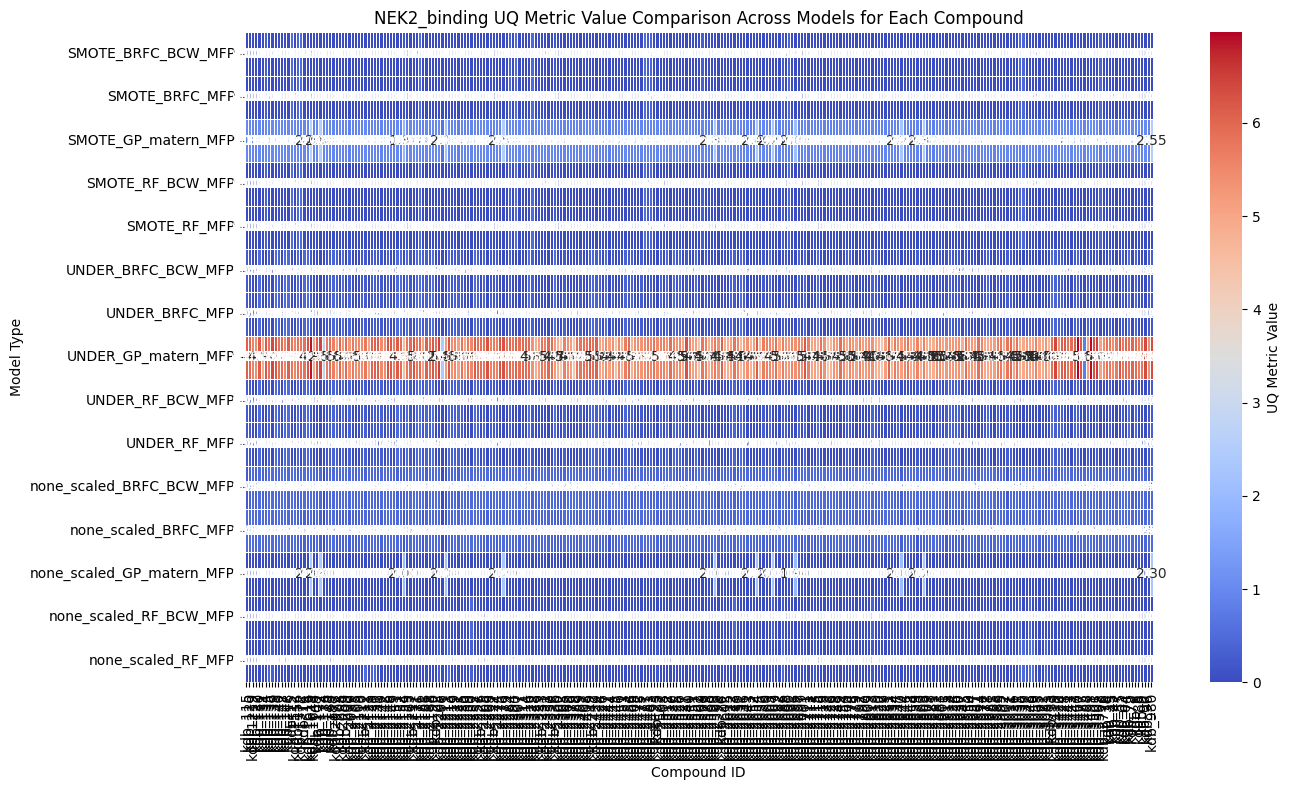

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

nekdf nas sum:  uq_0    0
uq_1    0
dtype: int64


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

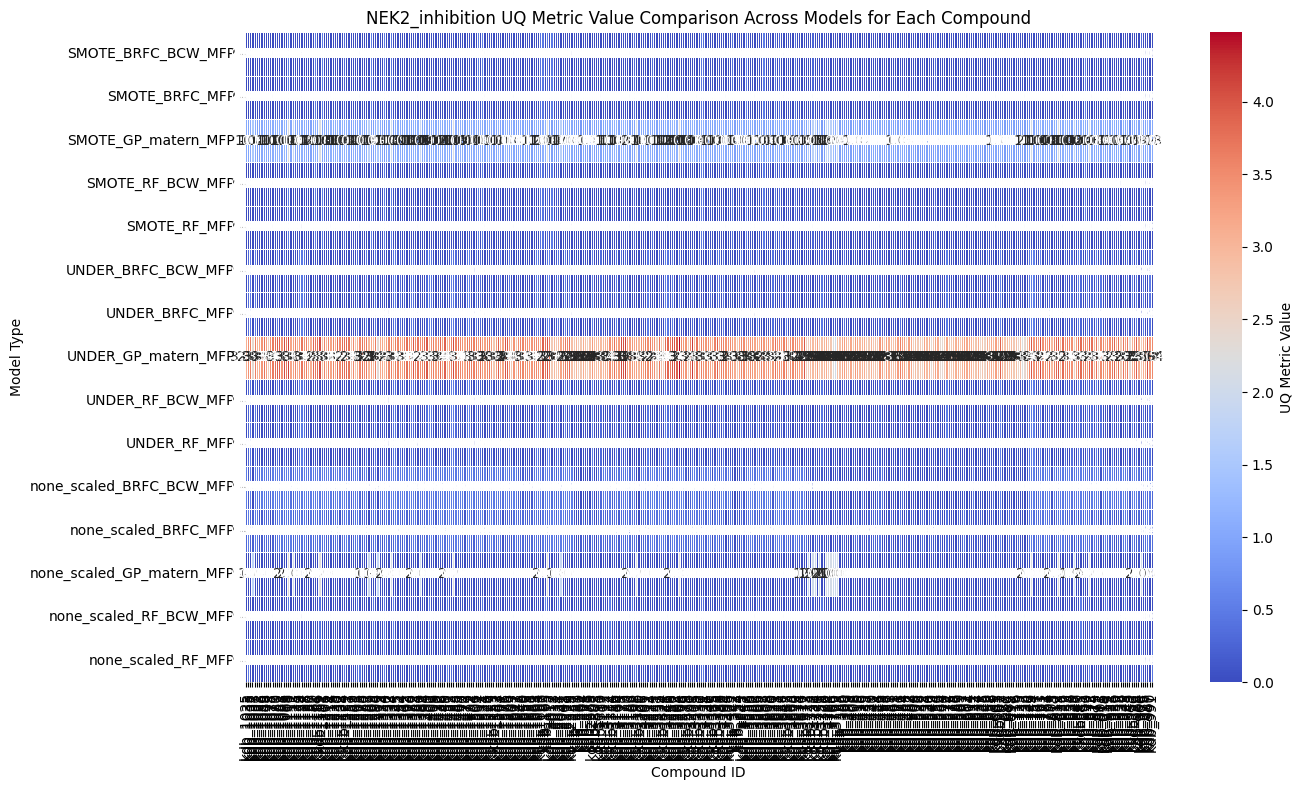

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

nekdf nas sum:  uq_0    0
uq_1    0
dtype: int64


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

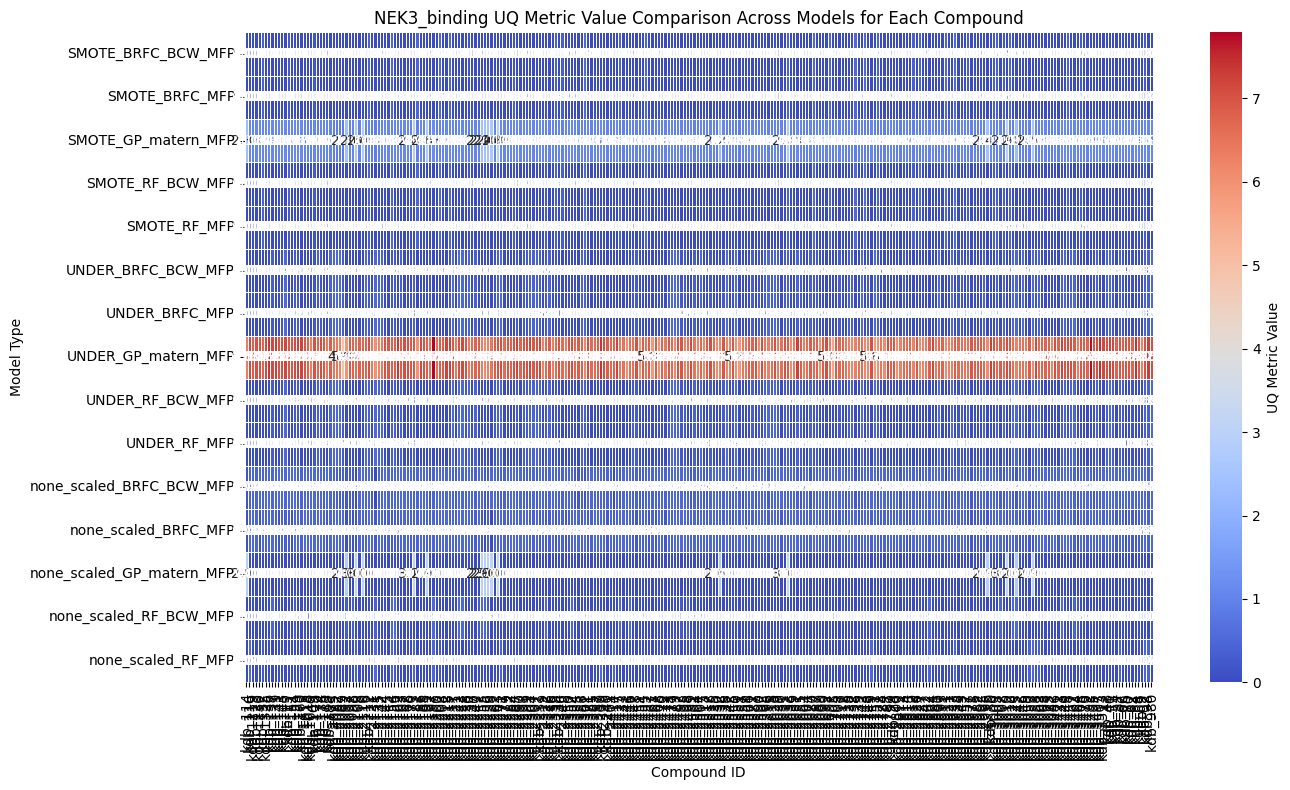

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

nekdf nas sum:  uq_0    0
uq_1    0
dtype: int64


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

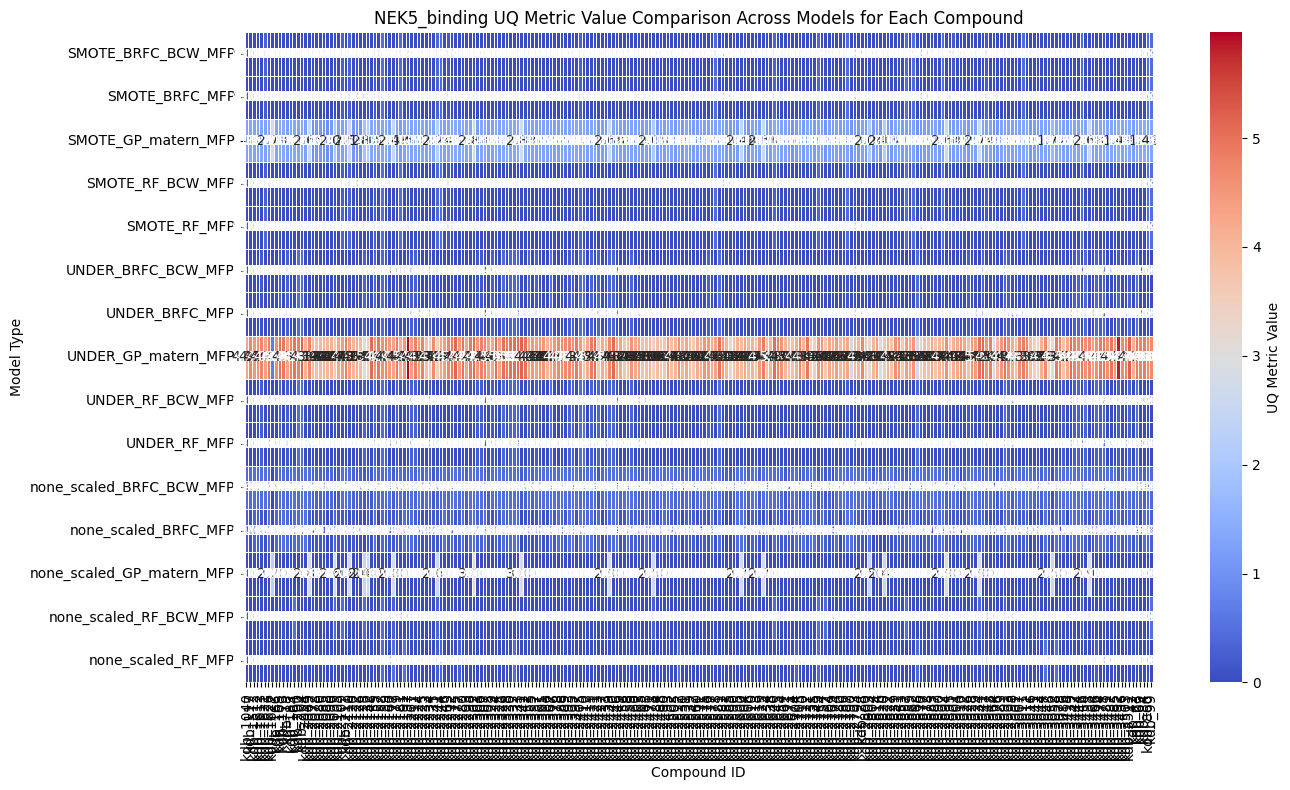

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

nekdf nas sum:  uq_0    0
uq_1    0
dtype: int64


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

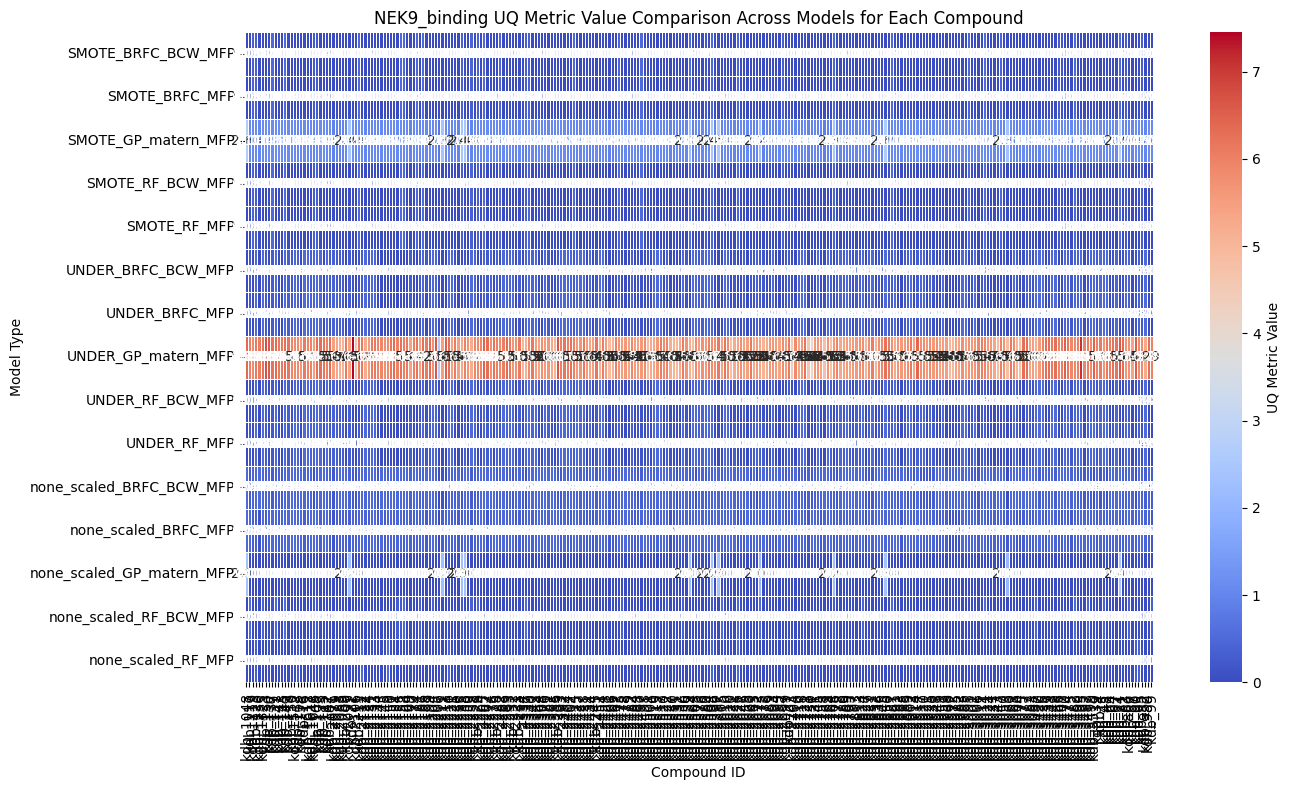

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

nekdf nas sum:  uq_0    0
uq_1    0
dtype: int64


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

per-model NaNs: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

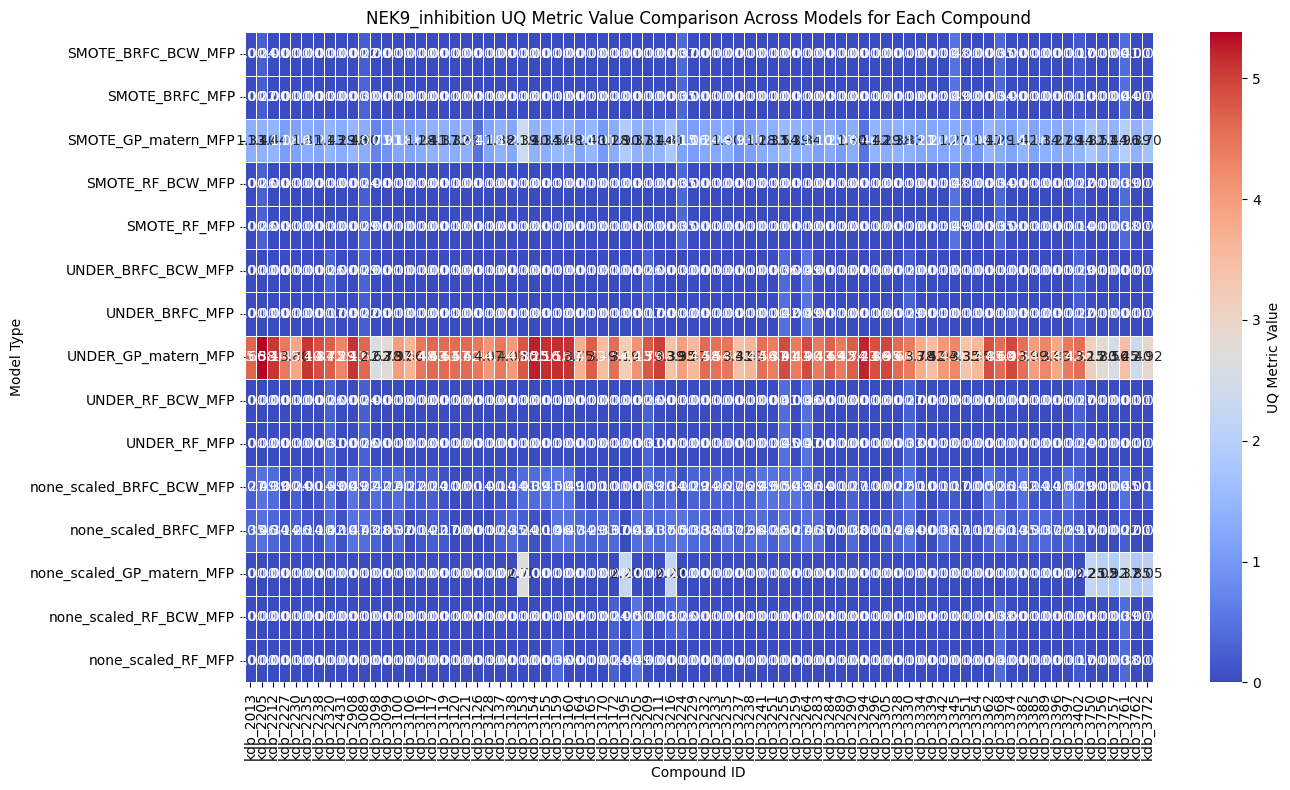

In [207]:
sampling_combos_rf = [('none_scaled','RF'),('none_scaled','RF_BCW'),('SMOTE','RF'), 
    ('none_scaled','BRFC'),('none_scaled','BRFC_BCW'),('UNDER','RF')]
samp_rf_list1 = [f'{samp}_{rf}' for samp, rf in sampling_combos_rf]
sampling_combos = [('none_scaled','RF'),('none_scaled','RF_BCW'),('SMOTE','RF'), 
    ('none_scaled','BRFC'),('none_scaled','BRFC_BCW'),('UNDER','RF'), ('SMOTE', 'GP_matern'),
                  ('none_scaled','GP_matern'), ('UNDER','GP_matern')]
samp_list = [f'{samp}_{m}' for samp,m in sampling_combos]
id_vars = ['compound_id', 'feat_type', 'NEK', 'strategy', 'modeling_type', 'model_version', 'set']
# rf first
for nek in neks:
    all_model_test_cmpds=[] 
    # nek_df = pd.read_csv(f'{new_cmpd_df_path}test_set/{nek}_MFP_{samp}_{model}_cmpd_class.csv')
    nek_df = pd.read_csv(f'{new_cmpd_df_path}test_set/{nek}_all_models_testset.csv')
    for col in ['uq_0', 'uq_1']:
        nek_df[col] = pd.to_numeric(nek_df[col], errors='coerce')
    print('nekdf nas sum: ',nek_df[['uq_0', 'uq_1']].isna().sum())

    

    for samp in samplings: 
        for m in RF_types:
            
            df=pd.read_csv(f'{new_cmpd_df_path}test_set/{nek}_MFP_{samp}_{m}_cmpd_class.csv')
            cmpd_set = set(df['compound_id'].values)
            all_model_test_cmpds.append(cmpd_set)
            print('per-model NaNs:', df['UQ_metric_value'].isna().sum())
            

    intersection_set = set.intersection(*all_model_test_cmpds)

    comparison_df = nek_df[nek_df['compound_id'].isin(intersection_set)]
    comparison_df = (nek_df[nek_df['compound_id'].isin(intersection_set)].reset_index(drop=True))
    # comparison_df = comparison_df[comparison_df['model_version'].isin(samp_list)]
    comparison_df['model name']=comparison_df['model_version'].astype(str)+ '_'+comparison_df['feat_type']

    # print('comparison df nas',comparison_df[comparison_df['UQ_metric_value'].isna()].groupby('model name').size())
    
    melted_df = comparison_df.melt(
    id_vars=id_vars,  
    value_vars=['UQ_metric_value'], var_name='metric',  value_name='UQ_metric')
    
    
    # melted_df.to_csv(f'{new_cmpd_df_path}test_set/{nek}_RF_models_UQ.csv', index=False)
    common_cmpds = list(intersection_set)
    wide_df = comparison_df.pivot_table(index='model name',columns='compound_id', 
                                        values='UQ_metric_value') 
    
     
    # wide_df.to_csv(f'{new_cmpd_df_path}test_set/{nek}_RF_models_UQ_wide.csv', index=False)
    
    plt.figure(figsize=(14, 8))

    sns.heatmap(wide_df, cmap='coolwarm', annot=True, fmt='.2f', 
        cbar_kws={'label': 'UQ Metric Value'}, 
        linewidths=0.5,xticklabels=True,yticklabels=True)
    
    plt.title(f'{nek} UQ Metric Value Comparison Across Models for Each Compound')
    plt.xlabel('Compound ID')
    plt.ylabel('Model Type')
    plt.xticks(rotation=90)  
    plt.tight_layout()
    # plt.savefig(f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/compare_across/figs/{nek}.png')
    plt.show()
    

In [87]:
for nek in neks:
    short_nek = nek[:4]
    nb_all_model_test_cmpds=[] 
    nb_nek_df = pd.read_csv(f'{new_cmpd_df_path}nanobret/{nek}_all_models_nanobret.csv')

    for samp in samplings: 
        for m in RF_types:
            
            df=pd.read_csv(f'{new_cmpd_df_path}nanobret/{nek}_MFP_{samp}_{m}_cmpd_class.csv')
            cmpd_set = set(df['compound_id'].values)
            all_model_test_cmpds.append(cmpd_set)
    print(nek)
    intersection_set = set.intersection(*all_model_test_cmpds)
    comparison_df = nek_df[nek_df['compound_id'].isin(intersection_set)]
    
    comparison_df = comparison_df[comparison_df['model_version'].isin(samp_list)]
    comparison_df['model name']=comparison_df['model_version'].astype(str)+ '_'+comparison_df['feat_type']
    display(comparison_df['compound_id'].unique)
    print(comparison_df['model name'].unique())
    melted_df = comparison_df.melt(
    id_vars=['compound_id', 'feat_type', 'NEK', 'strategy', 'modeling_type', 'model_version'],  
    value_vars=['UQ_metric_value'], var_name='metric',  value_name='UQ_metric')
    melted_df.to_csv(f'{new_cmpd_df_path}test_set/{nek}_RF_models_UQ.csv', index=False)
    common_cmpds = list(intersection_set)
    wide_df = comparison_df.pivot_table(index='model name',columns='compound_id', 
                                        values='UQ_metric_value')        
    display(wide_df)
    wide_df.to_csv(f'{new_cmpd_df_path}nanobret/{nek}_RF_models_UQ_wide.csv', index=False)
    plt.figure(figsize=(14, 8))

    sns.heatmap(wide_df, cmap='coolwarm', annot=True, fmt='.2f', 
        cbar_kws={'label': 'UQ Metric Value'}, 
        linewidths=0.5,xticklabels=True,yticklabels=True)
    
    plt.title(f'{nek} UQ Metric Value Comparison Across Models for Each Compound')
    plt.xlabel('Compound ID')
    plt.ylabel('Model Type')
    plt.xticks(rotation=90)  
    plt.tight_layout()
    # plt.savefig(f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/compare_across/figs/{nek}.png')
    plt.show()

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jayceepang/msse/ATOM_CODE/UQ/compound_TNFPFNTP/nanobret/NEK2_binding_all_models_nanobret.csv'

# plot for classifcation types (TP, FP, etc.)

In [ ]:
for nek in neks:
    all_model_test_cmpds=[] 
    nek_df = pd.read_csv(f'{cmpd_df_path}{nek}_all_models.csv')
    for feat in feat_types: 
        for samp in samplings: 
            for m in RF_types:
                df=pd.read_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_{m}_cmpd_class.csv')
                cmpd_set = set(df['compound_id'].values)
                all_model_test_cmpds.append(cmpd_set)
    print(nek)
    intersection_set = set.intersection(*all_model_test_cmpds)
    comparison_df = nek_df[nek_df['compound_id'].isin(intersection_set)]
    
    
    comparison_df = comparison_df[comparison_df['model_version'].isin(samp_list)]
    comparison_df['model_version']=comparison_df['model_version'].str.replace('none_scaled','Orig')
    comparison_df['model name']=comparison_df['model_version'].astype(str)+ '_'+comparison_df['feat_type']

    melted_df = comparison_df.melt(
    id_vars=['compound_id', 'feat_type', 'NEK', 'strategy', 'modeling_type', 'model_version', 'prediction_type'],  
    value_vars=['UQ_metric_value'], var_name='metric',  value_name='UQ_metric')
    common_cmpds = list(intersection_set)
    for pred_type in melted_df['prediction_type'].unique(): 
        prediction_type_df = comparison_df[comparison_df['prediction_type']==pred_type] 
        wide_df = prediction_type_df.pivot_table(index='model name',columns='compound_id', 
                                            values='UQ_metric_value')  
        
        print(wide_df.shape)
        # display(melted_df)
        plt.figure(figsize=(14, 8))
        wide_df =wide_df.dropna(axis=1) 
        # if wide_df.empty or wide_df.isna().all().all():
        #     print(f'{nek}: no {pred_type}')
        #     continue
        # else: 
        #     sns.heatmap(wide_df, cmap='coolwarm', annot=True, fmt='.2f', 
        #         cbar_kws={'label': 'UQ Metric Value'}, 
        #         linewidths=0.5,xticklabels=True,yticklabels=True)
            
        #     plt.title(f'{nek} UQ Metric Value Comparison Across Models for Each Compound {pred_type} molecules')
        #     plt.xlabel('Compound ID')
        #     plt.ylabel('Model Type')
        #     plt.xticks(rotation=90)  
        #     plt.tight_layout()
        #     plt.show()
        

In [ ]:
prod_models = ['UNDER_GP_matern', 'none_scaled_BRFC']
for nek in neks:
    all_model_test_cmpds=[] 
    nek_df = pd.read_csv(f'{cmpd_df_path}{nek}_all_models.csv')
    for samp in ['none_scaled', 'UNDER']: 
        for m in prod_models:
            df=pd.read_csv(f'{cmpd_df_path}{nek}_MFP_{m}_cmpd_class.csv')
            print(m)
            cmpd_set = set(df['compound_id'].values)
            all_model_test_cmpds.append(cmpd_set)
    print(nek)
    intersection_set = set.intersection(*all_model_test_cmpds)
    comparison_df = nek_df[nek_df['compound_id'].isin(intersection_set)]

    comparison_df = comparison_df[comparison_df['model_version'].isin(prod_models)]
    comparison_df=comparison_df[comparison_df['feat_type']=='MFP']
    # comparison_df['model_version']=comparison_df['model_version'].str.replace('none_scaled','Orig')
    comparison_df['model name']=comparison_df['model_version'].astype(str)+ '_'+comparison_df['feat_type']

    melted_df = comparison_df.melt(
    id_vars=['compound_id', 'feat_type', 'NEK', 'strategy', 'modeling_type', 'model_version', 'prediction_type'],  
    value_vars=['UQ_metric_value'], var_name='metric',  value_name='UQ_metric')
    common_cmpds = list(intersection_set)
    for pred_type in melted_df['prediction_type'].unique(): 
        prediction_type_df = comparison_df[comparison_df['prediction_type']==pred_type] 
        wide_df = prediction_type_df.pivot_table(index='model name',columns='compound_id', 
                                            values='UQ_metric_value')  
        
        print(wide_df.shape)
        # display(melted_df)
        plt.figure(figsize=(14, 8))
        wide_df =wide_df.dropna(axis=1) 
        if wide_df.empty or wide_df.isna().all().all():
            print(f'{nek}: no {pred_type}')
            continue
        else: 
            sns.heatmap(wide_df, cmap='coolwarm', annot=True, fmt='.2f', 
                cbar_kws={'label': 'UQ Metric Value'}, 
                linewidths=0.5,xticklabels=True,yticklabels=True)
            
            plt.title(f'{nek} UQ Metric Value Comparison Across Models for Each Compound {pred_type} molecules')
            plt.xlabel('Compound ID')
            plt.ylabel('Model Type')
            plt.xticks(rotation=90)  
            plt.tight_layout()
            plt.show()
        

In [ ]:
for nek in neks:
    nek_df = final_df[final_df['NEK'] == nek]
    nek_raw = nek_df[(nek_df['strategy'] == 'none_scaled') & (nek_df['model'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
    rf_other = nek_df[(nek_df['model'] == 'RF') & (nek_df['strategy'].isin(['UNDER', 'SMOTE']))] 
    gp=nek_df[nek_df['model']=='GP_matern'] 
    
    nek_df2 = pd.concat([nek_raw, rf_other, gp])
    nek_df2['model'] = nek_df2['model'].astype(str)+'_'+nek_df2['strategy']+ '_'+nek_df2['feat_type'] 
    all_model_types=nek_df2['model'].unique()
    fn_dict = {model: set(nek_df2[nek_df2['model']==model]['FN'].sum())for model in all_model_types}
    all_fn_cmpds = sorted(set.union(*fn_dict.values()))
    fn_matrix = pd.DataFrame(0, index=all_fn_cmpds, columns=fn_dict.keys())
    # display(fn_matrix)

    for model, cmpds in fn_dict.items():
        fn_matrix.loc[list(cmpds), (model)]=1
        # 1 = classified FN 

    plt.figure(figsize=(12,8))
    ax = sns.heatmap(fn_matrix, cmap='coolwarm', linewidths=0.5,cbar=False)
    fn_patch = mpatches.Patch(color=sns.color_palette('coolwarm', as_cmap=True)(1.0),label='FN (1)')
    not_fn_patch = mpatches.Patch(color=sns.color_palette("coolwarm", as_cmap=True)(0.0), label='Not FN (0)')
    
    plt.legend(handles=[fn_patch,not_fn_patch], loc='upper right', fontsize=12, title="Classification")

    plt.xlabel('Model',fontsize=15)
    plt.ylabel('Compound ID',fontsize=15)
    plt.title(f'{nek} compounds classified as FN for each model',fontsize=15)
    plt.xticks(rotation=90)

In [ ]:
#### final_df = pd.read_csv(f'{cmpd_df_path}list_of_mols_pred_types.csv')
import matplotlib.patches as mpatches
selected_models = ['BRFC', 'BRFC_BCW', 'RF', 'GP_matern']
selected_model_map = {'none_scaled': ['BRFC', 'BRFC_BCW'], 'UNDER': ['RF', 'GP_matern']}
for nek in neks:
    nek_models = []
    for samp, models in selected_model_map.items(): 
        for mod in models: 
            df = pd.read_csv(f'{cmpd_df_path}{nek}_MFP_{samp}_{mod}_cmpd_class.csv')
            df['model_version']=df['model_version'].astype(str)+'_MFP'
            fn_df = df[df['prediction_type'] == 'FN']
            # nek_models.append(df)
            nek_models.append(fn_df)
            
            # display(df)
    
    full_nek_df = pd.concat(nek_models, ignore_index=True)
    uq_matrix = full_nek_df.pivot_table(index='compound_id', columns='model_version', values='UQ_metric_value', aggfunc='mean')

    uq_matrix = uq_matrix.dropna(how='all')

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(uq_matrix, cmap='coolwarm', linewidths=0.5, annot=True,cbar_kws={'label': 'UQ Metric'})
    
    plt.xlabel('Model', fontsize=15)
    plt.ylabel('Compound ID (FN)', fontsize=15)
    plt.title(f'{nek} compounds, FN prediction-type UQ value', fontsize=15)
    plt.xticks(rotation=90)
    
    # plt.savefig(f"/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/compound_TNFPFNTP/model_FN/{nek}_FN_under_models_UQ.png", bbox_inches='tight')
    plt.show()


In [ ]:
uq_df['model_version'] = uq_df['strategy'].astype(str)+'_'+uq_df['modeling_type']+'_'+uq_df['feat_type']

In [ ]:
uq_df['model_version'].value_counts()

In [ ]:
model_shapes = {'UNDER_GP_matern': 'o', 'none_scaled_BRFC': 's','none_scaled_BRFC_BCW':'s'}
pred_types = {'TN': 'gray','FN': 'red', 'TP': 'green','FP': 'orange'}

In [ ]:
fig_path='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/compare_across/figs/UQ_point_comparison/'
for nek in neks:
    df_list = []
    model_list=[]
    for model in ['UNDER_GP_matern','none_scaled_BRFC'] : 
        
        if (nek=='NEK9_inhibition' and model=='none_scaled_BRFC'): 
            model ='none_scaled_BRFC_BCW'
        print(nek, model)
        model_list.append(model)
        df = pd.read_csv(f'{cmpd_df_path}{nek}_MFP_{model}_cmpd_class.csv')
        df_list.append(df) 
    
    merged = df_list[0].merge(df_list[1], on=['compound_id'], suffixes=('_GP', '_RF'))
    # display(nek_df)
    # display(merged)
    plot_df = pd.DataFrame({'compound_id':pd.concat([merged['compound_id'],merged['compound_id']]),
    'model': [model_list[0]] * len(merged)+ [model_list[1]]*len(merged),
    'UQ_metric': pd.concat([merged['UQ_metric_value_GP'], merged['UQ_metric_value_RF']]),
    'prediction_type': pd.concat([merged['prediction_type_GP'], merged['prediction_type_RF']])})
    # display(plot_df)
    plt.figure(figsize=(16, 6))
    sns.scatterplot(data=plot_df,x='compound_id',y='UQ_metric',hue='prediction_type',palette=pred_types,
        style='model',markers=model_shapes, s=100)
    plt.xticks(rotation=90)
    plt.title(f'{nek} UQ values')
    plt.tight_layout()
    # plt.savefig(f'{fig_path}{nek}.png', bbox_inches='tight')
    plt.show()
    
        

In [ ]:
fig_path2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/compare_across/figs/UQ_point_comparison/not_matching_TN/'
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
for nek in neks:
    df_list = []
    model_list=[]
    for model in ['UNDER_GP_matern','none_scaled_BRFC'] : 
        if (nek=='NEK9_inhibition' and model=='none_scaled_BRFC'): 
            model ='none_scaled_BRFC_BCW'
        print(nek, model)
        model_list.append(model)
        df = pd.read_csv(f'{cmpd_df_path}{nek}_MFP_{model}_cmpd_class.csv')
   
        df_list.append(df) 
    
    merged = df_list[0].merge(df_list[1], on=['compound_id'], suffixes=('_GP', '_RF'))
    mask =(merged['prediction_type_GP']=='TN') & (merged['prediction_type_RF'] == 'TN')
    temp=merged[~mask]
    plot_df = pd.DataFrame({'compound_id':pd.concat([temp['compound_id'],temp['compound_id']]),
    'model': [model_list[0]] * len(temp)+ [model_list[1]]*len(temp),
    'UQ_metric': pd.concat([temp['UQ_metric_value_GP'],temp['UQ_metric_value_RF']]),
    'prediction_type': pd.concat([temp['prediction_type_GP'], temp['prediction_type_RF']])})
    # display(plot_df)
    
    # plt.figure(figsize=(16, 6))
    fig,axs=plt.subplots(nrows=2, ncols=1, figsize=(18,9), sharex=True)
    gp_df = plot_df[plot_df['model']==model_list[0]]
    rf_df =  plot_df[plot_df['model']==model_list[1]]
    # display(plot_df)
   
    sns.scatterplot(data=gp_df,x='compound_id',y='UQ_metric',hue='prediction_type',palette=pred_types,
        style='model',markers=model_shapes, s=100, ax=axs[0],legend=False)
    sns.scatterplot(data=rf_df,x='compound_id',y='UQ_metric',hue='prediction_type',palette=pred_types,
        style='model',markers=model_shapes, s=100, ax=axs[1],legend=False)
    # axs[1].legend(bbox_to_anchor=(1,1))
   
    axs[0].set_xlabel('compound_id',fontsize=18)
    axs[0].set_ylabel('(GP)\nPredictive Variance',fontsize=18)
    axs[1].set_xlabel('compound_id',fontsize=18)
    axs[1].set_ylabel('(RF)\nSD of Prediction Probability',fontsize=18)
    # axs[1].tick_params(labelsize=20)
    fig.subplots_adjust(hspace=0)
    plt.xticks(rotation=90, fontsize=15)
    fig.suptitle(f'{nek} UQ values\n(excluding molecules where both models classified it as TN)',fontsize=20)
    legend2 = [Line2D([0],[0], marker='o', color='black', markerfacecolor='black', markersize=6, label='UNDER GP Matern')]
    
    handles, labels = axs[1].get_legend_handles_labels()
    handles+=legend2
    # axs[1].legend(handles=handles, labels=labels, title='Legend')
 
    plt.tight_layout()
    plt.savefig(f"{fig_path2}{nek}.png", bbox_inches='tight')
    plt.show()
    
        

# xy scatter 
RF UQ on x axis and GP UQ metric on y 


each point is a test set molecule

In [ ]:
fig_path='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/compare_across/figs/xy_scatter/'
from sklearn.metrics import *
from scipy.stats import *
for nek in neks:
    df_list = []
    model_list=[]
    for model in ['UNDER_GP_matern','none_scaled_BRFC'] : 
        
        if (nek=='NEK9_inhibition' and model=='none_scaled_BRFC'): 
            model ='none_scaled_BRFC_BCW'
        print(nek, model)
        model_list.append(model)
        df = pd.read_csv(f'{cmpd_df_path}{nek}_MFP_{model}_cmpd_class.csv')
        # model['model']= model_list['modeling_type'
   
        df_list.append(df) 
    
    merged = df_list[0].merge(df_list[1], on=['compound_id'], suffixes=('_GP', '_RF'))
    mask =(merged['prediction_type_GP']=='TN') & (merged['prediction_type_RF'] == 'TN')
    temp=merged[~mask]

    plt.figure(figsize=(14,10))

    sns.scatterplot(data=temp,x='UQ_metric_value_GP',y='UQ_metric_value_RF',s=100)
    pearson_corr, p_value = pearsonr(temp['UQ_metric_value_GP'],temp['UQ_metric_value_RF'])
    # sns.scatterplot(data=temp,x='UQ_metric_value_RF',y='UQ_metric_value_GP',s=100)
    # plt.xticks(rotation=90)
    r2= pearson_corr*pearson_corr
    rho, pval=spearmanr(temp['UQ_metric_value_GP'],temp['UQ_metric_value_RF'])
    plt.title(f'{nek} UQ values (excluding molecules predicted as TN by GP and RF)\nR2: {r2:.2f}; rho: {rho:.2f}', fontsize=18)
    plt.xlabel('UQ_metric_value_GP',fontsize=16)
    plt.ylabel('UQ_metric_value_RF',fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{fig_path}{nek}_xy_scatter_notTN_notmatching.png", bbox_inches='tight')
    plt.show()
        

In [ ]:
for nek in neks:
    df_list = []
    model_list=[]
    for model in ['UNDER_GP_matern','none_scaled_BRFC'] : 
        
        if (nek=='NEK9_inhibition' and model=='none_scaled_BRFC'): 
            model ='none_scaled_BRFC_BCW'
        print(nek, model)
        model_list.append(model)
        df = pd.read_csv(f'{cmpd_df_path}{nek}_MFP_{model}_cmpd_class.csv')
        # model['model']= model_list['modeling_type'
   
        df_list.append(df) 
    
    merged = df_list[0].merge(df_list[1], on=['compound_id'], suffixes=('_GP', '_RF'))

    plt.figure(figsize=(14,10))

    sns.scatterplot(data=merged,x='UQ_metric_value_GP',y='UQ_metric_value_RF',s=100)
    pearson_corr, p_value = pearsonr(merged['UQ_metric_value_GP'],merged['UQ_metric_value_RF'])
    r2= pearson_corr*pearson_corr
    rho, pval=spearmanr(merged['UQ_metric_value_GP'],merged['UQ_metric_value_RF'])
    plt.title(f'{nek} UQ values\nR2: {r2:.2f}; rho: {rho:.2f}', fontsize=18)
    plt.xlabel('UQ_metric_value_GP',fontsize=16)
    plt.ylabel('UQ_metric_value_RF',fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{fig_path}{nek}_xy_scatter.png", bbox_inches='tight')
    plt.show()
        